# Summary 

This notebook presents a full pipeline for image classification using deep learning. The structure includes data inspection, exploration, model training, evaluation, and submission preparation.

**1. Description of the Dataset**

- **1.1 Basic Information**: Introduces the dataset and its structure.
- **1.2 Image Details**: Discusses image dimensions and types.

**2. Exploratory Data Analysis (EDA)**

- Plots the first few images from both training and test sets.
- Examines pixel distributions.
- Confirms that the training data contains no missing values.

**3. Modeling**

3.1 Parameters

- Defines hyperparameters for training.

3.2 Data Preparation

- Loads image data.
- Applies data augmentation techniques.

3.3 Training

- Trains models over multiple epochs.
- Logs AUC and loss metrics for evaluation.
- Compares different architectures (ResNet50, InceptionV3, DenseNet121).

**4. Analysis of Model outcome**

**5. Submission**

- Uses the best-performing model (DenseNet121) to predict on the test set.
- Outputs results to `submission.csv` with image IDs and probability scores.


In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import matplotlib.pyplot as plt

import os
ROOT_PATH = '/kaggle/input/histopathologic-cancer-detection'

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


import re 

In [2]:
df = pd.read_csv(os.path.join(ROOT_PATH, 'train_labels.csv'))
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


# 1. Description of the data set

## 1.1. The basic information about the data set

In [3]:
positive_numbers = len(df[df['label'] ==1])
test_length = len(os.listdir(os.path.join(ROOT_PATH,'test')))
df_sample = pd.read_csv(os.path.join(ROOT_PATH,'sample_submission.csv'))
sample_length = len(df_sample)

print(f'The training data has 220,025 entries. \n{round(positive_numbers/len(df)*100,2)}% of which are positive (1), the others are negative (0).' )
print(f'- The test dataset has {test_length} entries.')
print(f'- We need to submit a file with {test_length} data entries, according to the submission requirement.')
print(f'- The length of submission data equals to {round(sample_length/220025*100,2)}% that of the training data.')

The training data has 220,025 entries. 
40.5% of which are positive (1), the others are negative (0).
- The test dataset has 57458 entries.
- We need to submit a file with 57458 data entries, according to the submission requirement.
- The length of submission data equals to 26.11% that of the training data.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


## 1.2. The images

In [5]:
train_images_path = os.path.join(ROOT_PATH,'train')
test_images_path = os.path.join(ROOT_PATH,'test')

print('Assume that all images in the train and test data set have the same size.')

with Image.open('/kaggle/input/histopathologic-cancer-detection/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif') as train_img:
    print(f' - The train image size is {train_img.size}.')

with Image.open('/kaggle/input/histopathologic-cancer-detection/test/00006537328c33e284c973d7b39d340809f7271b.tif') as test_img:
    print(f' - The test image size is {test_img.size}.')


Assume that all images in the train and test data set have the same size.
 - The train image size is (96, 96).
 - The test image size is (96, 96).


# 2. EDA

- Plot first three images in the training and test data set.

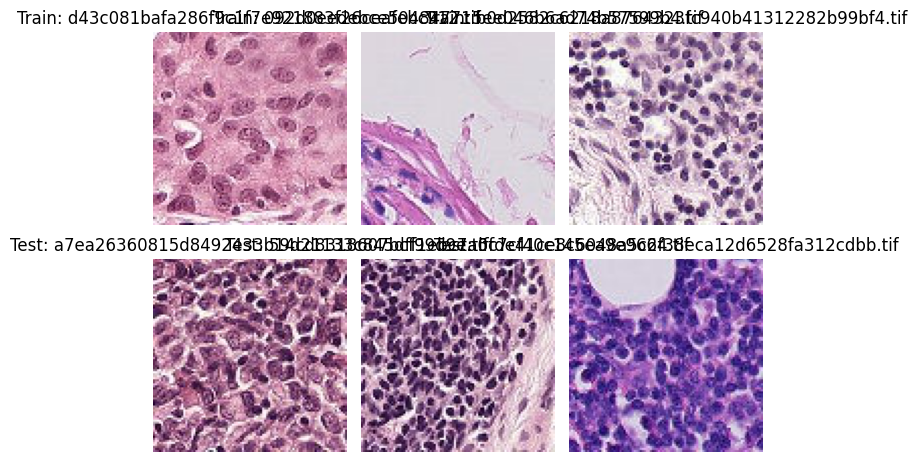

In [6]:
plot_train_images = os.listdir(train_images_path)[:3]
plot_test_images = os.listdir(test_images_path)[:3]


fig, ax = plt.subplots(2, 3)

for idx, fname in enumerate(plot_train_images):
    img = Image.open(os.path.join(train_images_path, fname))
    ax[0, idx].imshow(img)
    ax[0, idx].set_title(f"Train: {fname}")
    ax[0, idx].axis('off')

# Plot test images
for idx, fname in enumerate(plot_test_images):
    img = Image.open(os.path.join(test_images_path, fname))
    ax[1, idx].imshow(img)
    ax[1, idx].set_title(f"Test: {fname}")
    ax[1, idx].axis('off')

plt.tight_layout()
plt.show()


- Let's take a look at its pixel values.

In [7]:
np.array(Image.open(os.path.join(train_images_path, plot_train_images[0])))

array([[[241, 246, 250],
        [255, 251, 255],
        [246, 221, 243],
        ...,
        [206, 148, 173],
        [207, 151, 176],
        [220, 166, 190]],

       [[245, 242, 249],
        [255, 242, 255],
        [147, 115, 138],
        ...,
        [242, 184, 209],
        [252, 196, 221],
        [230, 176, 202]],

       [[255, 249, 255],
        [214, 187, 206],
        [211, 168, 195],
        ...,
        [210, 150, 176],
        [226, 167, 195],
        [200, 144, 171]],

       ...,

       [[226, 202, 216],
        [223, 201, 213],
        [255, 241, 250],
        ...,
        [237, 206, 221],
        [249, 222, 231],
        [255, 228, 235]],

       [[255, 245, 255],
        [248, 224, 238],
        [187, 165, 177],
        ...,
        [255, 247, 255],
        [255, 240, 253],
        [253, 227, 238]],

       [[241, 212, 232],
        [255, 231, 248],
        [250, 223, 238],
        ...,
        [232, 215, 225],
        [221, 201, 212],
        [187, 163, 176]]

- Check if there is any missing value in training data.

In [8]:
df.isna().any()

id       False
label    False
dtype: bool

- The train data has no missing value.

# 3. Modeling

In [ ]:

# --- Configuration ---
IMAGE_SIZE = 96
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
BATCH_SIZE = 64
EPOCHS = 10 # Start small, then increase. For a real submission, you'd train longer.
LEARNING_RATE = 1e-4

# --- Paths ---
# Adjust these paths if you're not running directly in a Kaggle notebook
TRAIN_DIR = '../input/histopathologic-cancer-detection/train'
TEST_DIR = '../input/histopathologic-cancer-detection/test'
TRAIN_LABELS_PATH = '../input/histopathologic-cancer-detection/train_labels.csv'
SAMPLE_SUBMISSION_PATH = '../input/histopathologic-cancer-detection/sample_submission.csv'


# --- 1. Data Loading and Preprocessing ---

# Load labels for training
train_labels_df = pd.read_csv(TRAIN_LABELS_PATH)

# Create full image paths for training
train_labels_df['path'] = train_labels_df['id'].apply(lambda x: os.path.join(TRAIN_DIR, f'{x}.tif'))

# Split data for training and validation
train_df, val_df = train_test_split(
    train_labels_df,
    test_size=0.15,
    stratify=train_labels_df['label'],
    random_state=42
)

# Data Augmentation (Crucial for Histopathology)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255) # Only rescale for validation

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)

# --- 2. Model Definition Function ---
def create_model(model_name='ResNet50', input_shape=INPUT_SHAPE, learning_rate=LEARNING_RATE):
    if model_name == 'VGG16':
        base_model = tf.keras.applications.VGG16(
            weights='imagenet', include_top=False, input_shape=input_shape
        )
    elif model_name == 'ResNet50':
        base_model = tf.keras.applications.ResNet50(
            weights='imagenet', include_top=False, input_shape=input_shape
        )
    elif model_name == 'InceptionV3':
        base_model = tf.keras.applications.InceptionV3(
            weights='imagenet', include_top=False, input_shape=input_shape
        )
    elif model_name == 'Xception':
        base_model = tf.keras.applications.Xception(
            weights='imagenet', include_top=False, input_shape=input_shape
        )
    elif model_name == 'DenseNet121':
        base_model = tf.keras.applications.DenseNet121(
            weights='imagenet', include_top=False, input_shape=input_shape
        )
    else:
        raise ValueError(f"Model {model_name} not supported.")

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

# --- 3. Training Loop for Comparison ---

models_to_compare = ['ResNet50', 'InceptionV3', 'DenseNet121'] # Reduced for quicker demo
results = {}

best_auc = 0
best_model_name_overall = None
best_model_weights = None

for model_name in models_to_compare:
    print(f"\n--- Training {model_name} ---")
    model = create_model(model_name=model_name)
    model.summary()

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.2, patience=3, mode='max', min_lr=1e-6)

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=val_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stopping, reduce_lr]
    )

    val_preds_raw = model.predict(val_generator, steps=val_generator.samples // BATCH_SIZE + 1)
    
    val_true = []
    val_generator.reset() # Reset generator to ensure correct order
    
    # Iterate through the generator to get labels
    for i in range(len(val_generator)):
        _, labels = val_generator[i] # Access batch directly using index
        val_true.extend(labels)
        
    val_true = np.array(val_true[:len(val_preds_raw)]) # Truncate to match predictions

    auc = roc_auc_score(val_true, val_preds_raw)
    print(f"Validation AUC for {model_name}: {auc:.4f}")

    results[model_name] = {'history': history.history, 'val_auc': auc}

    # Keep track of the best performing model to use for test predictions
    if auc > best_auc:
        best_auc = auc
        best_model_name_overall = model_name
        best_model_weights = model.get_weights() # Save weights of the best model

# --- 4. Summarize Results ---
print("\n--- Comparison Results ---")
for model_name, data in results.items():
    print(f"{model_name}: Validation AUC = {data['val_auc']:.4f}")

print(f"\nBest model for test prediction: {best_model_name_overall} with Validation AUC: {best_auc:.4f}")

# --- 5. Generate Predictions for Test Data and Create Submission CSV ---

print("\n--- Generating Test Predictions ---")

# Load sample submission to get test image IDs
test_df = pd.read_csv(SAMPLE_SUBMISSION_PATH)

# Get list of test image files
test_image_files = os.listdir(TEST_DIR)

# Create a DataFrame for test image paths, mimicking the train_df structure
# We only need the 'id' and 'path' for test prediction
# The 'label' column will be filled with dummy values as it's not used during inference
test_image_ids = [os.path.splitext(f)[0] for f in test_image_files if f.endswith('.tif')]
test_paths = [os.path.join(TEST_DIR, f'{img_id}.tif') for img_id in test_image_ids]

test_data = pd.DataFrame({'id': test_image_ids, 'path': test_paths, 'label': 0}) # 'label' is a dummy column

# Create a test generator (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='path',
    y_col='label', # Still needs a y_col, but its values aren't used for prediction
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False # Crucial: do not shuffle test data
)

# Instantiate the best performing model and load its weights
if best_model_name_overall:
    final_model = create_model(model_name=best_model_name_overall)
    final_model.set_weights(best_model_weights) # Load the saved best weights
else:
    print("No model was trained or no best model found. Exiting prediction phase.")
    exit()

# Predict probabilities on the test set
# Use steps argument to ensure all images are processed, even if not perfectly divisible by batch_size
test_predictions = final_model.predict(
    test_generator,
    steps=int(np.ceil(test_generator.samples / BATCH_SIZE))  # Cast to int
).flatten() # Flatten to get a 1D array of probabilities



2025-08-04 03:27:48.664862: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754278068.894759      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754278068.962903      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 187021 validated image filenames.
Found 33004 validated image filenames.

--- Training ResNet50 ---


I0000 00:00:1754278498.080001      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 102, 102,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 48, 48,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 48, 48,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 48, 48,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 50, 50,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 24, 24,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 24, 24,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 24, 24,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 24, 24,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 24, 24,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 24, 24,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 24, 24,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 24, 24,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 24, 24,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1754278515.478561      61 service.cc:148] XLA service 0x7bad1c003e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754278515.481526      61 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754278517.064806      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2922 ━━━━━━━━━━━━━━━━━━━━ 12:50:53 16s/step - auc: 0.5440 - loss: 0.7516

I0000 00:00:1754278520.925819      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2922/2922 ━━━━━━━━━━━━━━━━━━━━ 1650s 559ms/step - auc: 0.5921 - loss: 0.6676 - val_auc: 0.7349 - val_loss: 0.6138 - learning_rate: 1.0000e-04
Epoch 2/10
   1/2922 ━━━━━━━━━━━━━━━━━━━━ 1:19 27ms/step - auc: 0.6724 - loss: 0.6376

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2922/2922 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - auc: 0.6724 - loss: 0.6376 - val_auc: 0.7349 - val_loss: 0.6149 - learning_rate: 1.0000e-04
Epoch 3/10
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 634s 217ms/step - auc: 0.7513 - loss: 0.5895 - val_auc: 0.7642 - val_loss: 0.5883 - learning_rate: 1.0000e-04
Epoch 4/10
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - auc: 0.6786 - loss: 0.6315 - val_auc: 0.7642 - val_loss: 0.5886 - learning_rate: 1.0000e-04
Epoch 5/10
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 614s 210ms/step - auc: 0.7690 - loss: 0.5677 - val_auc: 0.7806 - val_loss: 0.5931 - learning_rate: 1.0000e-04
Epoch 6/10
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 36s 12ms/step - auc: 0.7582 - loss: 0.5473 - val_auc: 0.7806 - val_loss: 0.5942 - learning_rate: 1.0000e-04
Epoch 7/10
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 618s 212ms/step - auc: 0.7813 - loss: 0.5543 - val_auc: 0.7885 - val_loss: 0.5729 - learning_rate: 1.0000e-04
Epoch 8/10
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - auc: 0.8333 - loss: 0.4941 - val_auc: 0.7888 - 

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 47, 47,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 47, 47,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 47, 47,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 45, 45,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 45, 45,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 22, 22,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 22, 22,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 22,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 22, 22,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 20, 20,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 20,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 20, 20,    │          0 │ batch_normalizat

 Total params: 22,327,585 (85.17 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/10
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 659s 219ms/step - auc: 0.8171 - loss: 0.5152 - val_auc: 0.8908 - val_loss: 0.4054 - learning_rate: 1.0000e-04
Epoch 2/10
   1/2922 ━━━━━━━━━━━━━━━━━━━━ 1:06 23ms/step - auc: 0.8402 - loss: 0.4772

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2922/2922 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - auc: 0.8402 - loss: 0.4772 - val_auc: 0.8907 - val_loss: 0.4062 - learning_rate: 1.0000e-04
Epoch 3/10
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 648s 222ms/step - auc: 0.8725 - loss: 0.4346 - val_auc: 0.8997 - val_loss: 0.3901 - learning_rate: 1.0000e-04
Epoch 4/10
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - auc: 0.9062 - loss: 0.3854 - val_auc: 0.8997 - val_loss: 0.3898 - learning_rate: 1.0000e-04
Epoch 5/10
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 699s 239ms/step - auc: 0.8802 - loss: 0.4219 - val_auc: 0.9031 - val_loss: 0.3865 - learning_rate: 1.0000e-04
Epoch 6/10
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - auc: 0.8148 - loss: 0.5052 - val_auc: 0.9031 - val_loss: 0.3867 - learning_rate: 1.0000e-04
Epoch 7/10
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 797s 273ms/step - auc: 0.8834 - loss: 0.4174 - val_auc: 0.9067 - val_loss: 0.3777 - learning_rate: 1.0000e-04
Epoch 8/10
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - auc: 0.8682 - loss: 0.4230 - val_auc: 0.9067 - 

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 102, 102,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 48, 48,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 48, 48,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 48, 48,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 50, 50,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 24, 24,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 24, 24,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 24, 24,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 24, 24,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 24, 24,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 24, 24,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 24, 24,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 24, 24,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 24, 24,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 24, 24,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 24, 24,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/10
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 832s 275ms/step - auc: 0.8469 - loss: 0.4696 - val_auc: 0.9248 - val_loss: 0.3386 - learning_rate: 1.0000e-04
Epoch 2/10
   1/2922 ━━━━━━━━━━━━━━━━━━━━ 1:25 29ms/step - auc: 0.8744 - loss: 0.4480

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2922/2922 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - auc: 0.8744 - loss: 0.4480 - val_auc: 0.9249 - val_loss: 0.3387 - learning_rate: 1.0000e-04
Epoch 3/10
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 795s 272ms/step - auc: 0.9142 - loss: 0.3602 - val_auc: 0.9329 - val_loss: 0.3200 - learning_rate: 1.0000e-04
Epoch 4/10
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - auc: 0.8539 - loss: 0.4390 - val_auc: 0.9329 - val_loss: 0.3199 - learning_rate: 1.0000e-04
Epoch 5/10
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 792s 271ms/step - auc: 0.9214 - loss: 0.3443 - val_auc: 0.9359 - val_loss: 0.3120 - learning_rate: 1.0000e-04
Epoch 6/10
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - auc: 0.9489 - loss: 0.3084 - val_auc: 0.9359 - val_loss: 0.3120 - learning_rate: 1.0000e-04
Epoch 7/10
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 788s 269ms/step - auc: 0.9265 - loss: 0.3339 - val_auc: 0.9395 - val_loss: 0.3037 - learning_rate: 1.0000e-04
Epoch 8/10
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - auc: 0.9037 - loss: 0.3656 - val_auc: 0.9395 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 442s 480ms/step
Submission file created successfully at: submission.csv
Submission head:
                                         id     label
0  a7ea26360815d8492433b14cd8318607bcf99d9e  0.747850
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664  0.069345
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb  0.208318
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0  0.721573
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62  0.077627


# 4 Analysis of the Model Outcome

**Training Performance**
- Over 10 epochs, the validation AUC improved from approximately 0.91 to **0.9405**.
- Validation loss decreased from about 0.345 to **0.3005**.
- A constant learning rate of `1e-4` was used throughout training.

**Insight**: Training was effective and well-regularized, with no clear signs of overfitting.

---

**Model Comparison Results**

| Model         | Validation AUC |
|--------------|----------------|
| DenseNet121  | 0.9405         |
| InceptionV3  | 0.9071         |
| ResNet50     | 0.7867         |

**Conclusion**: DenseNet121 outperformed other models in terms of AUC and was selected for test predictions.

---

**Test Predictions and Submission**
- Number of test images: **57,458**
- Predictions are provided as probabilities (for binary classification).
- Example predictions from `submission.csv`:



# 5. Prepare the submission file

In [ ]:
# Create the submission DataFrame
submission_df = pd.DataFrame({'id': test_image_ids, 'label': test_predictions})

# Save to CSV
submission_csv_path = 'submission.csv'
submission_df.to_csv(submission_csv_path, index=False)

print(f"Submission file created successfully at: {submission_csv_path}")
print(f"Submission head:\n{submission_df.head()}")